# EDA - VNHSGE Dataset (Vietnamese National High School Graduation Examination)

Notebook này phân tích chi tiết dataset **VNHSGE** - Đề thi THPT Quốc gia Việt Nam.

## Cấu trúc dataset:
- **train/**: Dữ liệu training từ đề thi 2019-2023 (có đáp án)
  - 9 môn học: Biology, Chemistry, CivicEducation, English, Geography, History, Literature, Mathematics, Physics
- **val/**: Dữ liệu validation (có đáp án)
  - 3 môn: CivicEducation, Geography, History
- **test/**: Dữ liệu test (có/không đáp án - cần kiểm tra)
  - 3 môn: CivicEducation, Geography, History

## Đặc điểm:
- Format JSON với các trường: ID, Image_Question, Question, Choice, Image_Answer, Explanation
- Một số câu hỏi có hình ảnh đi kèm
- Câu hỏi trắc nghiệm 4 lựa chọn (A/B/C/D)

In [26]:
# Import thư viện
import json
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import numpy as np

# Cấu hình
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.rcParams['font.family'] = 'DejaVu Sans'

print("✅ Import thành công!")

✅ Import thành công!


## 1. Scan và Load toàn bộ Dataset

In [ ]:
# Đường dẫn gốc
BASE_DIR = "../data/VNHSGE/Dataset/VNHSGE-V/JSON format"

# Hàm load tất cả JSON files từ một folder
def load_all_json_files(folder_path):
    """Load tất cả file JSON trong folder và subfolders"""
    all_data = []
    json_files = glob.glob(os.path.join(folder_path, "**/*.json"), recursive=True)
    
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # Thêm metadata
                subject = os.path.basename(os.path.dirname(json_file))
                filename = os.path.basename(json_file)
                
                for item in data:
                    item['_subject'] = subject
                    item['_filename'] = filename
                    item['_filepath'] = json_file
                    all_data.append(item)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return all_data

# Load data từ 3 splits
print("🔄 Đang load dữ liệu...")
train_data = load_all_json_files(os.path.join(BASE_DIR, "train"))
val_data = load_all_json_files(os.path.join(BASE_DIR, "val"))
test_data = load_all_json_files(os.path.join(BASE_DIR, "test"))

print(f"\n📊 Thống kê:")
print(f"  Train: {len(train_data)} samples")
print(f"  Val:   {len(val_data)} samples")
print(f"  Test:  {len(test_data)} samples")
print(f"  TỔNG:  {len(train_data) + len(val_data) + len(test_data)} samples")

🔄 Đang load dữ liệu...

📊 Thống kê:
  Train: 1730 samples
  Val:   4800 samples
  Test:  597 samples
  TỔNG:  7127 samples


## 2. Xem cấu trúc dữ liệu mẫu

In [28]:
# Xem sample từ train
print("="*100)
print("📝 SAMPLE TỪ TRAIN SET (Mathematics):")
print("="*100)
math_samples = [s for s in train_data if 'Math' in s.get('_subject', '')]
if math_samples:
    sample = math_samples[0]
    print(f"ID: {sample['ID']}")
    print(f"Subject: {sample['_subject']}")
    print(f"Filename: {sample['_filename']}")
    print(f"\nCâu hỏi: {sample['Question'][:300]}...")
    print(f"\nĐáp án: {sample['Choice']}")
    print(f"Có hình ảnh câu hỏi: {'Có' if sample['Image_Question'] else 'Không'}")
    print(f"Có hình ảnh đáp án: {'Có' if sample['Image_Answer'] else 'Không'}")
    print(f"\nGiải thích: {sample['Explanation'][:200]}...")

print("\n" + "="*100)
print("📝 SAMPLE TỪ TEST SET:")
print("="*100)
if test_data:
    sample = test_data[0]
    print(f"ID: {sample['ID']}")
    print(f"Subject: {sample['_subject']}")
    print(f"\nCâu hỏi: {sample['Question'][:300]}...")
    print(f"\nĐáp án: {sample.get('Choice', 'KHÔNG CÓ')}")
    print(f"Có Explanation: {'Có' if sample.get('Explanation') else 'Không'}")

📝 SAMPLE TỪ TRAIN SET (Mathematics):
ID: MET_Math_IE_2019_1
Subject: Mathematics
Filename: MET_Math_IE_2019.json

Câu hỏi: Câu 1) Thể tích của khối lập phương cạnh 2a bằng:
A. 8a^3. 
B. 2a^3. 
C. a^3.   
D. 6a^3....

Đáp án: A
Có hình ảnh câu hỏi: Không
Có hình ảnh đáp án: Không

Giải thích: Thể tích của khối lập phương có cạnh bằng 2a là: V=\left(2a\right)^3=8a^3....

📝 SAMPLE TỪ TEST SET:
ID: Civ_38_1
Subject: CivicEducation

Câu hỏi: Câu 1:Yếu tố nào dưới đây là tư liệu lao động của người nông dân?
A. Không khí
B. Sợi để dệt vải
C. Máy cày
D. Vật liệu xây dựng...

Đáp án: C
Có Explanation: Có


## 3. Phân tích theo môn học (Subject)

📚 Phân bố theo môn học:

TRAIN:
  Biology             :   200 samples
  Chemistry           :   200 samples
  CivicEducation      :   200 samples
  English             :   250 samples
  Geography           :   200 samples
  History             :   200 samples
  Literature          :    30 samples
  Mathematics         :   250 samples
  Physics             :   200 samples

VAL:
  CivicEducation      :  1600 samples
  Geography           :  1600 samples
  History             :  1600 samples

TEST:
  CivicEducation      :   197 samples
  Geography           :   200 samples
  History             :   200 samples


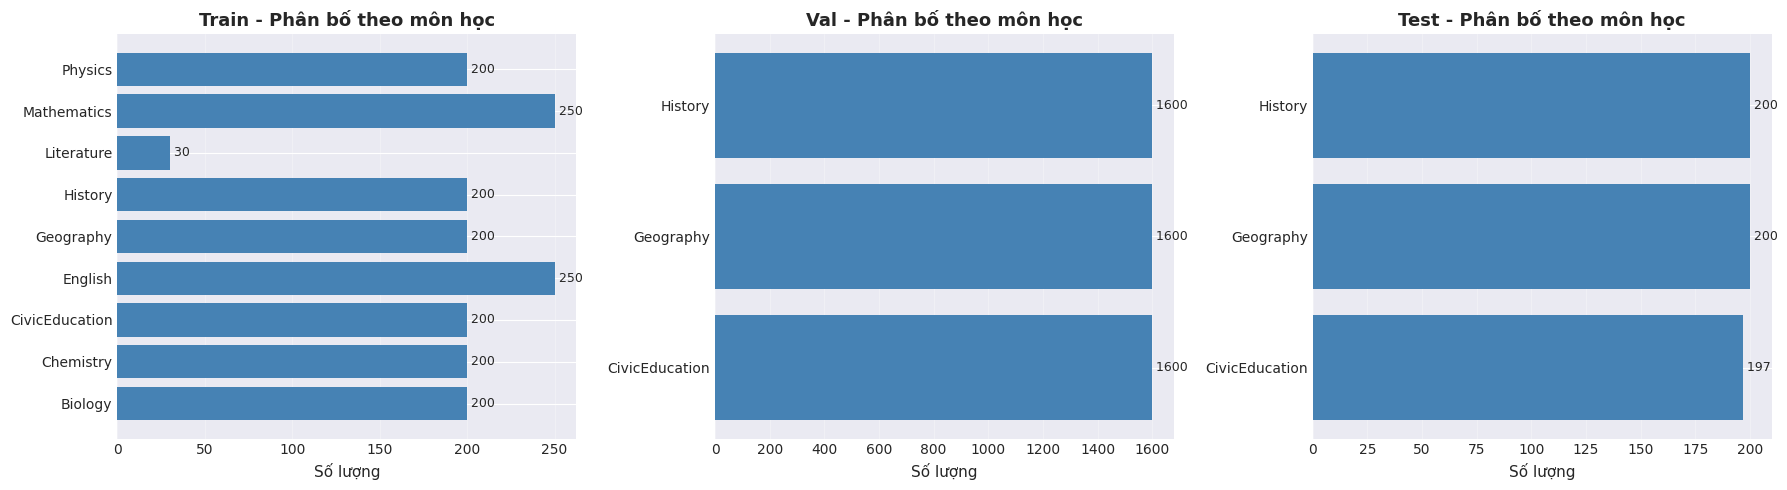

In [29]:
# Thống kê theo môn học
def count_by_subject(data):
    subjects = [item['_subject'] for item in data]
    return Counter(subjects)

train_subjects = count_by_subject(train_data)
val_subjects = count_by_subject(val_data)
test_subjects = count_by_subject(test_data)

print("📚 Phân bố theo môn học:\n")
print("TRAIN:")
for subject, count in sorted(train_subjects.items()):
    print(f"  {subject:20s}: {count:5d} samples")

print("\nVAL:")
for subject, count in sorted(val_subjects.items()):
    print(f"  {subject:20s}: {count:5d} samples")

print("\nTEST:")
for subject, count in sorted(test_subjects.items()):
    print(f"  {subject:20s}: {count:5d} samples")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, subjects_count, title in zip(axes, 
                                       [train_subjects, val_subjects, test_subjects],
                                       ['Train', 'Val', 'Test']):
    if subjects_count:
        subjects = list(subjects_count.keys())
        counts = list(subjects_count.values())
        ax.barh(subjects, counts, color='steelblue')
        ax.set_xlabel('Số lượng', fontsize=11)
        ax.set_title(f'{title} - Phân bố theo môn học', fontsize=13, fontweight='bold')
        ax.grid(alpha=0.3, axis='x')
        
        # Thêm số liệu
        for i, v in enumerate(counts):
            ax.text(v, i, f' {v}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 4. Phân tích phân bố đáp án (A/B/C/D)

📊 Phân bố đáp án:

TRAIN:
  A:   508 (29.88%)
  B:   421 (24.76%)
  C:   407 (23.94%)
  D:   364 (21.41%)

VAL:
  A:  1231 (25.70%)
  B:  1241 (25.91%)
  C:  1247 (26.04%)
  D:  1070 (22.34%)

TEST:
  A:   156 (26.17%)
  B:   136 (22.82%)
  C:   161 (27.01%)
  D:   142 (23.83%)
  r:     1 (0.17%)


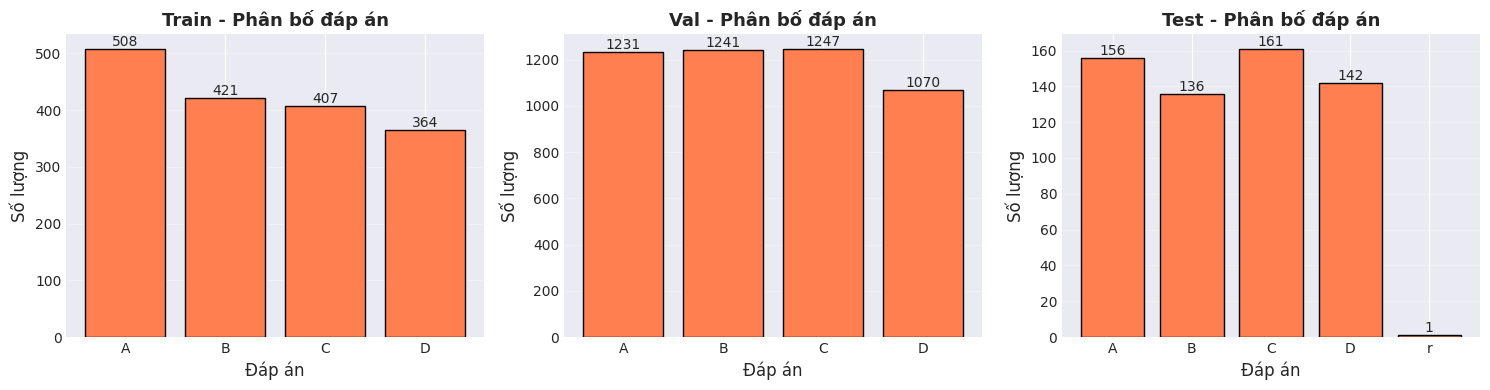

In [30]:
# Phân tích phân bố đáp án
def count_answers(data):
    answers = [item.get('Choice', '') for item in data if item.get('Choice')]
    return Counter(answers)

train_answers = count_answers(train_data)
val_answers = count_answers(val_data)
test_answers = count_answers(test_data)

print("📊 Phân bố đáp án:\n")
print("TRAIN:")
total_train = sum(train_answers.values())
for answer in sorted(train_answers.keys()):
    count = train_answers[answer]
    pct = count/total_train*100 if total_train > 0 else 0
    print(f"  {answer}: {count:5d} ({pct:.2f}%)")

print("\nVAL:")
total_val = sum(val_answers.values())
for answer in sorted(val_answers.keys()):
    count = val_answers[answer]
    pct = count/total_val*100 if total_val > 0 else 0
    print(f"  {answer}: {count:5d} ({pct:.2f}%)")

print("\nTEST:")
total_test = sum(test_answers.values())
if total_test > 0:
    for answer in sorted(test_answers.keys()):
        count = test_answers[answer]
        pct = count/total_test*100
        print(f"  {answer}: {count:5d} ({pct:.2f}%)")
else:
    print("  ❌ Test set KHÔNG có đáp án")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, answers, title in zip(axes, 
                               [train_answers, val_answers, test_answers],
                               ['Train', 'Val', 'Test']):
    if answers:
        ans_list = sorted(answers.keys())
        counts = [answers[a] for a in ans_list]
        ax.bar(ans_list, counts, color='coral', edgecolor='black')
        ax.set_xlabel('Đáp án', fontsize=12)
        ax.set_ylabel('Số lượng', fontsize=12)
        ax.set_title(f'{title} - Phân bố đáp án', fontsize=13, fontweight='bold')
        ax.grid(alpha=0.3, axis='y')
        
        # Thêm số liệu
        for i, (a, c) in enumerate(zip(ans_list, counts)):
            ax.text(i, c, f'{c}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Phân tích câu hỏi có hình ảnh

In [31]:
# Phân tích câu hỏi có hình ảnh
def count_image_questions(data):
    total = len(data)
    has_q_img = sum(1 for item in data if item.get('Image_Question'))
    has_a_img = sum(1 for item in data if item.get('Image_Answer'))
    has_both = sum(1 for item in data if item.get('Image_Question') and item.get('Image_Answer'))
    
    return {
        'total': total,
        'has_q_img': has_q_img,
        'has_a_img': has_a_img,
        'has_both': has_both,
        'no_img': total - has_q_img - has_a_img + has_both
    }

train_img = count_image_questions(train_data)
val_img = count_image_questions(val_data)
test_img = count_image_questions(test_data)

print("🖼️ Phân tích câu hỏi có hình ảnh:\n")
for name, img_stats in [('TRAIN', train_img), ('VAL', val_img), ('TEST', test_img)]:
    print(f"{name}:")
    print(f"  Tổng:                    {img_stats['total']}")
    print(f"  Có hình ảnh câu hỏi:     {img_stats['has_q_img']} ({img_stats['has_q_img']/img_stats['total']*100:.1f}%)")
    print(f"  Có hình ảnh đáp án:      {img_stats['has_a_img']} ({img_stats['has_a_img']/img_stats['total']*100:.1f}%)")
    print(f"  Có cả 2 loại hình:       {img_stats['has_both']}")
    print(f"  Không có hình:           {img_stats['no_img']}")
    print()

# Phân tích theo môn
def count_images_by_subject(data):
    subject_imgs = defaultdict(lambda: {'q': 0, 'a': 0, 'total': 0})
    for item in data:
        subj = item['_subject']
        subject_imgs[subj]['total'] += 1
        if item.get('Image_Question'):
            subject_imgs[subj]['q'] += 1
        if item.get('Image_Answer'):
            subject_imgs[subj]['a'] += 1
    return subject_imgs

train_subj_imgs = count_images_by_subject(train_data)

print("📊 Tỉ lệ câu hỏi có hình ảnh theo môn (Train):")
for subj in sorted(train_subj_imgs.keys()):
    stats = train_subj_imgs[subj]
    pct_q = stats['q']/stats['total']*100 if stats['total'] > 0 else 0
    pct_a = stats['a']/stats['total']*100 if stats['total'] > 0 else 0
    print(f"  {subj:20s}: {pct_q:5.1f}% (Q), {pct_a:5.1f}% (A)")

🖼️ Phân tích câu hỏi có hình ảnh:

TRAIN:
  Tổng:                    1730
  Có hình ảnh câu hỏi:     97 (5.6%)
  Có hình ảnh đáp án:      53 (3.1%)
  Có cả 2 loại hình:       23
  Không có hình:           1603

VAL:
  Tổng:                    4800
  Có hình ảnh câu hỏi:     70 (1.5%)
  Có hình ảnh đáp án:      0 (0.0%)
  Có cả 2 loại hình:       0
  Không có hình:           4730

TEST:
  Tổng:                    597
  Có hình ảnh câu hỏi:     9 (1.5%)
  Có hình ảnh đáp án:      0 (0.0%)
  Có cả 2 loại hình:       0
  Không có hình:           588

📊 Tỉ lệ câu hỏi có hình ảnh theo môn (Train):
  Biology             :   5.0% (Q),   0.0% (A)
  Chemistry           :   2.0% (Q),   0.0% (A)
  CivicEducation      :   0.0% (Q),   0.0% (A)
  English             :   0.0% (Q),   0.0% (A)
  Geography           :   5.0% (Q),   0.0% (A)
  History             :   0.0% (Q),   0.0% (A)
  Literature          :   0.0% (Q),   0.0% (A)
  Mathematics         :  21.2% (Q),  12.4% (A)
  Physics             :  

## 6. Phân tích độ dài câu hỏi

📏 Độ dài câu hỏi (ký tự):

TRAIN:
  Min:    58
  Max:    3115
  Mean:   355.2
  Median: 237.0
  P90:    530.2
  P95:    1236.1

VAL:
  Min:    70
  Max:    1118
  Mean:   276.9
  Median: 257.0
  P90:    416.0
  P95:    474.0

TEST:
  Min:    82
  Max:    1678
  Mean:   293.4
  Median: 258.0
  P90:    435.0
  P95:    498.0



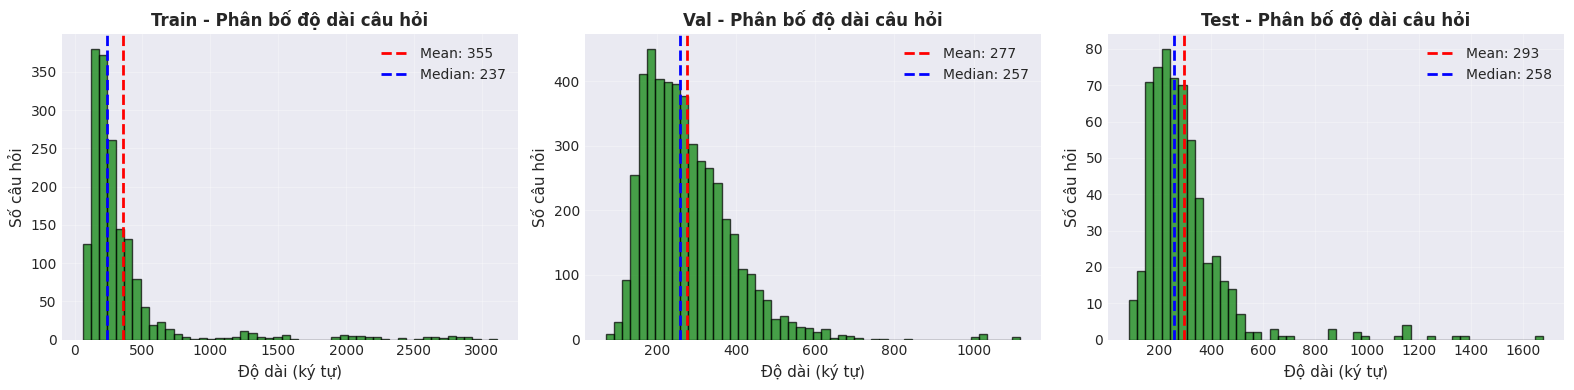

In [32]:
# Phân tích độ dài câu hỏi
def get_question_lengths(data):
    return [len(item['Question']) for item in data if item.get('Question')]

train_q_lens = get_question_lengths(train_data)
val_q_lens = get_question_lengths(val_data)
test_q_lens = get_question_lengths(test_data)

print("📏 Độ dài câu hỏi (ký tự):\n")
for name, lens in [('TRAIN', train_q_lens), ('VAL', val_q_lens), ('TEST', test_q_lens)]:
    if lens:
        print(f"{name}:")
        print(f"  Min:    {min(lens)}")
        print(f"  Max:    {max(lens)}")
        print(f"  Mean:   {np.mean(lens):.1f}")
        print(f"  Median: {np.median(lens):.1f}")
        print(f"  P90:    {np.percentile(lens, 90):.1f}")
        print(f"  P95:    {np.percentile(lens, 95):.1f}")
        print()

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, lens, title in zip(axes, 
                            [train_q_lens, val_q_lens, test_q_lens],
                            ['Train', 'Val', 'Test']):
    if lens:
        ax.hist(lens, bins=50, color='green', alpha=0.7, edgecolor='black')
        ax.axvline(np.mean(lens), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(lens):.0f}')
        ax.axvline(np.median(lens), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(lens):.0f}')
        ax.set_xlabel('Độ dài (ký tự)', fontsize=11)
        ax.set_ylabel('Số câu hỏi', fontsize=11)
        ax.set_title(f'{title} - Phân bố độ dài câu hỏi', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Phân tích độ dài Explanation

📝 Độ dài Explanation (ký tự):

TRAIN:
  Số câu có explanation: 1700
  Min:    22
  Max:    3339
  Mean:   270.2
  Median: 169.0

VAL:
  Số câu có explanation: 4800
  Min:    1
  Max:    2750
  Mean:   217.7
  Median: 150.0

TEST:
  Số câu có explanation: 597
  Min:    31
  Max:    1188
  Mean:   182.0
  Median: 147.0



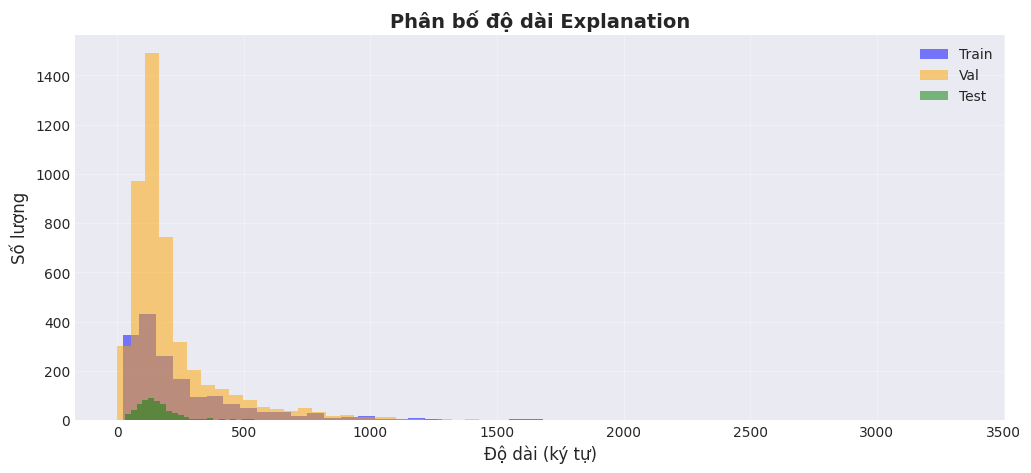

In [33]:
# Phân tích explanation
def get_explanation_lengths(data):
    return [len(item.get('Explanation', '')) for item in data if item.get('Explanation')]

train_exp_lens = get_explanation_lengths(train_data)
val_exp_lens = get_explanation_lengths(val_data)
test_exp_lens = get_explanation_lengths(test_data)

print("📝 Độ dài Explanation (ký tự):\n")
for name, lens in [('TRAIN', train_exp_lens), ('VAL', val_exp_lens), ('TEST', test_exp_lens)]:
    if lens:
        print(f"{name}:")
        print(f"  Số câu có explanation: {len(lens)}")
        print(f"  Min:    {min(lens)}")
        print(f"  Max:    {max(lens)}")
        print(f"  Mean:   {np.mean(lens):.1f}")
        print(f"  Median: {np.median(lens):.1f}")
        print()
    else:
        print(f"{name}: Không có explanation")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
if train_exp_lens:
    ax.hist(train_exp_lens, bins=50, alpha=0.5, label='Train', color='blue')
if val_exp_lens:
    ax.hist(val_exp_lens, bins=50, alpha=0.5, label='Val', color='orange')
if test_exp_lens:
    ax.hist(test_exp_lens, bins=50, alpha=0.5, label='Test', color='green')

ax.set_xlabel('Độ dài (ký tự)', fontsize=12)
ax.set_ylabel('Số lượng', fontsize=12)
ax.set_title('Phân bố độ dài Explanation', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## 8. Ước lượng tokens cho training

In [34]:
# Ước lượng tokens
# Giả sử: 1 token ≈ 4 ký tự tiếng Việt
def estimate_tokens(data):
    total_lens = []
    for item in data:
        q_len = len(item.get('Question', ''))
        exp_len = len(item.get('Explanation', ''))
        total_lens.append(q_len + exp_len)
    return total_lens

train_total_lens = estimate_tokens(train_data)
val_total_lens = estimate_tokens(val_data)
test_total_lens = estimate_tokens(test_data)

print("🔢 Ước lượng tokens (1 token ≈ 4 chars):\n")
for name, lens in [('TRAIN', train_total_lens), ('VAL', val_total_lens), ('TEST', test_total_lens)]:
    if lens:
        max_chars = max(lens)
        mean_chars = np.mean(lens)
        p95_chars = np.percentile(lens, 95)
        
        print(f"{name}:")
        print(f"  Max chars:  {max_chars:.0f}  →  ~{max_chars/4:.0f} tokens")
        print(f"  Mean chars: {mean_chars:.0f}  →  ~{mean_chars/4:.0f} tokens")
        print(f"  P95 chars:  {p95_chars:.0f}  →  ~{p95_chars/4:.0f} tokens")
        print()

# Gợi ý MAX_SEQ_LENGTH
all_lens = train_total_lens + val_total_lens + test_total_lens
max_all = max(all_lens) if all_lens else 0
suggested_max_seq = int(max_all / 4 * 1.3)  # Buffer 30%

print(f"💡 Gợi ý MAX_SEQ_LENGTH: {suggested_max_seq} tokens (với buffer 30%)")

🔢 Ước lượng tokens (1 token ≈ 4 chars):

TRAIN:
  Max chars:  5532  →  ~1383 tokens
  Mean chars: 615  →  ~154 tokens
  P95 chars:  1811  →  ~453 tokens

VAL:
  Max chars:  3123  →  ~781 tokens
  Mean chars: 495  →  ~124 tokens
  P95 chars:  1046  →  ~262 tokens

TEST:
  Max chars:  2353  →  ~588 tokens
  Mean chars: 475  →  ~119 tokens
  P95 chars:  906  →  ~227 tokens

💡 Gợi ý MAX_SEQ_LENGTH: 1797 tokens (với buffer 30%)


## 9. Phân tích phân bố đáp án theo từng môn học

📊 Phân bố đáp án theo môn học (Train):

Biology:
  A:   66 ( 33.0%)
  B:   48 ( 24.0%)
  C:   39 ( 19.5%)
  D:   47 ( 23.5%)

Chemistry:
  A:   58 ( 29.0%)
  B:   50 ( 25.0%)
  C:   52 ( 26.0%)
  D:   40 ( 20.0%)

CivicEducation:
  A:   52 ( 26.0%)
  B:   54 ( 27.0%)
  C:   53 ( 26.5%)
  D:   41 ( 20.5%)

English:
  A:   73 ( 29.2%)
  B:   65 ( 26.0%)
  C:   59 ( 23.6%)
  D:   53 ( 21.2%)

Geography:
  A:   62 ( 31.0%)
  B:   53 ( 26.5%)
  C:   45 ( 22.5%)
  D:   40 ( 20.0%)

History:
  A:   65 ( 32.5%)
  B:   43 ( 21.5%)
  C:   49 ( 24.5%)
  D:   43 ( 21.5%)

Mathematics:
  A:   68 ( 27.2%)
  B:   66 ( 26.4%)
  C:   57 ( 22.8%)
  D:   59 ( 23.6%)

Physics:
  A:   64 ( 32.0%)
  B:   42 ( 21.0%)
  C:   53 ( 26.5%)
  D:   41 ( 20.5%)



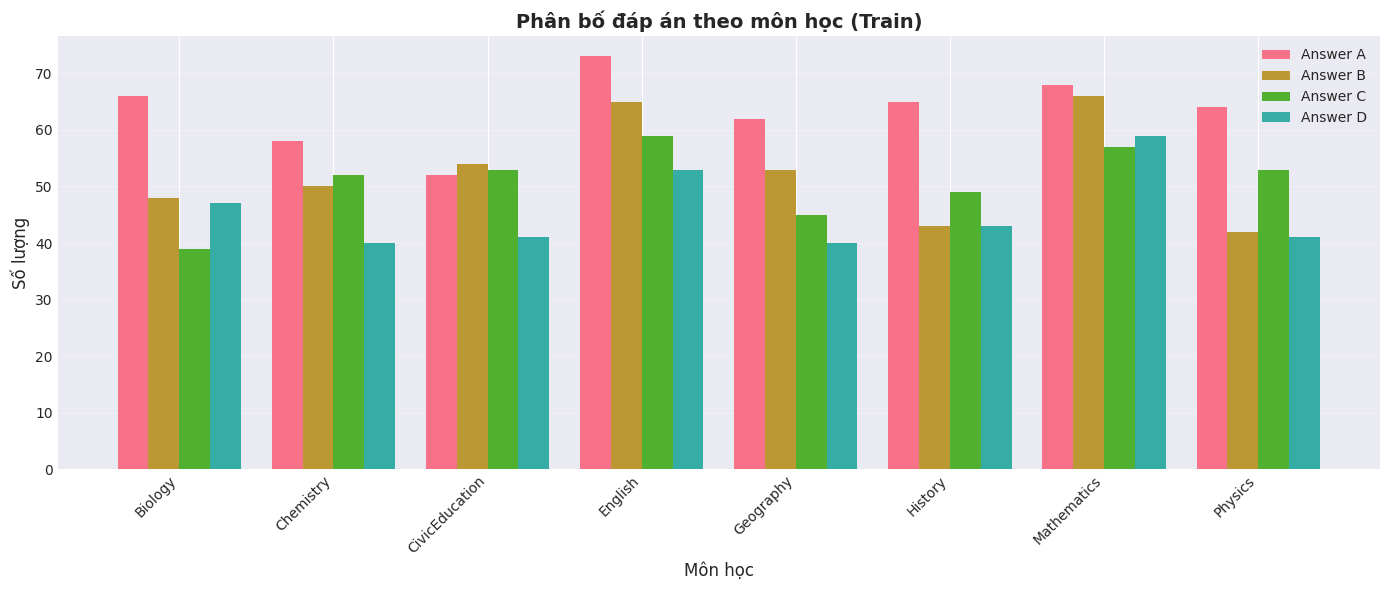

In [35]:
# Phân tích đáp án theo môn
def analyze_answers_by_subject(data):
    subject_answers = defaultdict(lambda: Counter())
    for item in data:
        if item.get('Choice'):
            subj = item['_subject']
            subject_answers[subj][item['Choice']] += 1
    return subject_answers

train_subj_ans = analyze_answers_by_subject(train_data)

print("📊 Phân bố đáp án theo môn học (Train):\n")
for subj in sorted(train_subj_ans.keys()):
    ans_counts = train_subj_ans[subj]
    total = sum(ans_counts.values())
    print(f"{subj}:")
    for ans in sorted(ans_counts.keys()):
        count = ans_counts[ans]
        pct = count/total*100
        print(f"  {ans}: {count:4d} ({pct:5.1f}%)")
    print()

# Visualize
subjects = sorted(train_subj_ans.keys())
answer_types = sorted(set(ans for subj in train_subj_ans.values() for ans in subj.keys()))

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(subjects))
width = 0.2

for i, ans in enumerate(answer_types):
    counts = [train_subj_ans[subj][ans] for subj in subjects]
    ax.bar(x + i*width, counts, width, label=f'Answer {ans}')

ax.set_xlabel('Môn học', fontsize=12)
ax.set_ylabel('Số lượng', fontsize=12)
ax.set_title('Phân bố đáp án theo môn học (Train)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(subjects, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Chuyển đổi sang format SFT (JSON-only)

In [36]:
# Hàm chuyển đổi sang format SFT
def convert_to_sft_format(item, include_answer=True):
    """
    Chuyển đổi sang format SFT với messages.
    Lưu ý: Bỏ qua câu hỏi có hình ảnh (cần xử lý riêng)
    Bỏ qua môn Văn (Literature) vì không phải multiple choice
    """
    # Bỏ qua nếu không có Question
    if not item.get('Question'):
        return None
    
    # Bỏ qua môn Văn (Literature) - không phải trắc nghiệm
    if 'Literature' in item.get('_subject', ''):
        return None
    
    # Bỏ qua nếu có hình ảnh
    if item.get('Image_Question') or item.get('Image_Answer'):
        return None
    
    # Format câu hỏi (đã có A/B/C/D trong Question)
    question_text = item['Question']
    user_content = f"{question_text}"
    
    # System prompt
    system_content = 'Bạn là trợ lý trả lời trắc nghiệm. Chỉ trả JSON duy nhất: {"answer":"A"} hoặc B/C/D.'
    
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_content}
    ]
    
    # Thêm assistant nếu có answer
    if include_answer and item.get('Choice'):
        messages.append({
            "role": "assistant",
            "content": f'{{"answer":"{item["Choice"]}"}}'
        })
    
    return {
        "messages": messages,
        "id": item.get('ID', ''),
        "subject": item.get('_subject', '')
    }

# Ví dụ chuyển đổi
no_img_samples = [s for s in train_data if not s.get('Image_Question') and not s.get('Image_Answer')]
if no_img_samples:
    sample_sft = convert_to_sft_format(no_img_samples[0])
    print("📝 Ví dụ format SFT (JSON-only):")
    print(json.dumps(sample_sft, ensure_ascii=False, indent=2))

📝 Ví dụ format SFT (JSON-only):
{
  "messages": [
    {
      "role": "system",
      "content": "Bạn là trợ lý trả lời trắc nghiệm. Chỉ trả JSON duy nhất: {\"answer\":\"A\"} hoặc B/C/D."
    },
    {
      "role": "user",
      "content": "Câu 81: Có thể sử dụng hóa chất nào sau đây để phát hiện quá trình hô hấp ở thực vật thải ra khí CO2? \nA. Dung dịch NaCl. \nB. Dung dịch Ca(OH)2. \nC. Dung dịch KCl. \nD. Dung dịch H2SO4."
    },
    {
      "role": "assistant",
      "content": "{\"answer\":\"B\"}"
    }
  ],
  "id": "MET_Bio_IE_2019_1",
  "subject": "Biology"
}


## 11. Export Dataset SFT (chỉ câu hỏi không có hình)

In [ ]:
# Export dataset không có hình ảnh
output_dir = "../data/sft_dataset_vnhsge"
os.makedirs(output_dir, exist_ok=True)

# Lọc câu không có hình và convert
def filter_and_convert(data):
    results = []
    skipped = 0
    for item in data:
        sft = convert_to_sft_format(item)
        if sft:
            results.append(sft)
        else:
            skipped += 1
    return results, skipped

print("🔄 Đang chuyển đổi dataset...\n")

train_sft, train_skip = filter_and_convert(train_data)
val_sft, val_skip = filter_and_convert(val_data)
test_sft, test_skip = filter_and_convert(test_data)

print(f"TRAIN: {len(train_sft)} samples (bỏ {train_skip} câu có hình)")
print(f"VAL:   {len(val_sft)} samples (bỏ {val_skip} câu có hình)")
print(f"TEST:  {len(test_sft)} samples (bỏ {test_skip} câu có hình)")

# Lưu thành JSONL
def save_jsonl(data, filepath):
    with open(filepath, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

# Lưu riêng từng split
save_jsonl(train_sft, os.path.join(output_dir, "train_sft.jsonl"))
save_jsonl(val_sft, os.path.join(output_dir, "val_sft.jsonl"))
save_jsonl(test_sft, os.path.join(output_dir, "test_sft.jsonl"))

# Combine train + val
combined_sft = train_sft + val_sft
save_jsonl(combined_sft, os.path.join(output_dir, "train_val_combined_sft.jsonl"))

print(f"\n✅ Đã export vào: {output_dir}/")
print(f"  - train_sft.jsonl: {len(train_sft)} samples")
print(f"  - val_sft.jsonl: {len(val_sft)} samples")
print(f"  - test_sft.jsonl: {len(test_sft)} samples")
print(f"  - train_val_combined_sft.jsonl: {len(combined_sft)} samples")
print(f"\n💡 Sử dụng file combined để train!")

🔄 Đang chuyển đổi dataset...

TRAIN: 1573 samples (bỏ 157 câu có hình)
VAL:   4730 samples (bỏ 70 câu có hình)
TEST:  588 samples (bỏ 9 câu có hình)

✅ Đã export vào: data/sft_dataset_vnhsge/
  - train_sft.jsonl: 1573 samples
  - val_sft.jsonl: 4730 samples
  - test_sft.jsonl: 588 samples
  - train_val_combined_sft.jsonl: 6303 samples

💡 Sử dụng file combined để train!


## 11.1. Thống kê số lượng theo môn học trong SFT Dataset

📊 Số lượng samples theo môn học trong SFT Dataset:

TRAIN SFT:
  Biology             :   190 samples
  Chemistry           :   196 samples
  CivicEducation      :   200 samples
  English             :   250 samples
  Geography           :   190 samples
  History             :   200 samples
  Mathematics         :   180 samples
  Physics             :   167 samples

  TỔNG                :  1573 samples

VAL SFT:
  CivicEducation      :  1600 samples
  Geography           :  1530 samples
  History             :  1600 samples

  TỔNG                :  4730 samples

COMBINED (Train + Val) SFT:
  Biology             :   190 samples
  Chemistry           :   196 samples
  CivicEducation      :  1800 samples
  English             :   250 samples
  Geography           :  1720 samples
  History             :  1800 samples
  Mathematics         :   180 samples
  Physics             :   167 samples

  TỔNG                :  6303 samples

📉 So sánh: Dataset gốc vs SFT (sau khi lọc)
Môn học       

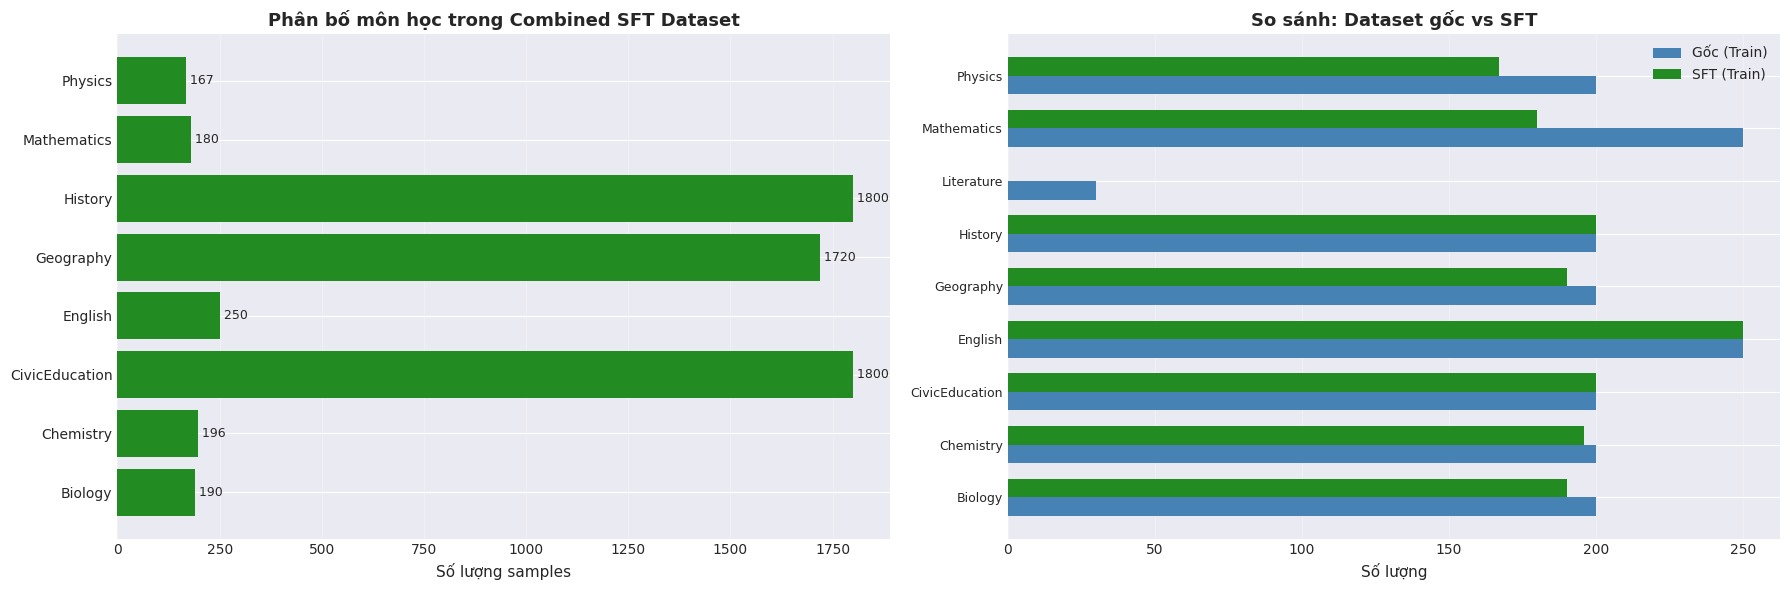


💡 Lưu ý:
  - Môn Literature (Văn) đã bị loại bỏ hoàn toàn vì không phải multiple choice
  - Các môn khác bị giảm do loại bỏ câu hỏi có hình ảnh
  - Tỉ lệ giữ lại phụ thuộc vào số lượng câu hỏi có hình trong từng môn


In [39]:
# Thống kê số lượng theo môn học trong SFT dataset
def count_sft_by_subject(sft_data):
    """Đếm số lượng samples theo môn học trong SFT dataset"""
    subjects = [item['subject'] for item in sft_data if item.get('subject')]
    return Counter(subjects)

print("📊 Số lượng samples theo môn học trong SFT Dataset:\n")

train_sft_subjects = count_sft_by_subject(train_sft)
val_sft_subjects = count_sft_by_subject(val_sft)
combined_sft_subjects = count_sft_by_subject(combined_sft)

print("=" * 80)
print("TRAIN SFT:")
print("=" * 80)
for subject in sorted(train_sft_subjects.keys()):
    count = train_sft_subjects[subject]
    print(f"  {subject:20s}: {count:5d} samples")
print(f"\n  {'TỔNG':20s}: {sum(train_sft_subjects.values()):5d} samples")

print("\n" + "=" * 80)
print("VAL SFT:")
print("=" * 80)
for subject in sorted(val_sft_subjects.keys()):
    count = val_sft_subjects[subject]
    print(f"  {subject:20s}: {count:5d} samples")
print(f"\n  {'TỔNG':20s}: {sum(val_sft_subjects.values()):5d} samples")

print("\n" + "=" * 80)
print("COMBINED (Train + Val) SFT:")
print("=" * 80)
for subject in sorted(combined_sft_subjects.keys()):
    count = combined_sft_subjects[subject]
    print(f"  {subject:20s}: {count:5d} samples")
print(f"\n  {'TỔNG':20s}: {sum(combined_sft_subjects.values()):5d} samples")

# So sánh với dataset gốc
print("\n" + "=" * 80)
print("📉 So sánh: Dataset gốc vs SFT (sau khi lọc)")
print("=" * 80)
print(f"{'Môn học':20s} {'Gốc (Train)':>12s} {'SFT (Train)':>12s} {'Tỉ lệ giữ lại':>15s}")
print("-" * 80)

for subject in sorted(train_subjects.keys()):
    original = train_subjects[subject]
    sft_count = train_sft_subjects.get(subject, 0)
    ratio = (sft_count / original * 100) if original > 0 else 0
    print(f"{subject:20s} {original:12d} {sft_count:12d} {ratio:14.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Chart 1: Combined SFT distribution
ax1 = axes[0]
if combined_sft_subjects:
    subjects = sorted(combined_sft_subjects.keys())
    counts = [combined_sft_subjects[s] for s in subjects]
    ax1.barh(subjects, counts, color='forestgreen')
    ax1.set_xlabel('Số lượng samples', fontsize=11)
    ax1.set_title('Phân bố môn học trong Combined SFT Dataset', fontsize=13, fontweight='bold')
    ax1.grid(alpha=0.3, axis='x')
    
    # Thêm số liệu
    for i, v in enumerate(counts):
        ax1.text(v, i, f' {v}', va='center', fontsize=9)

# Chart 2: Comparison (Original vs SFT)
ax2 = axes[1]
subjects = sorted(train_subjects.keys())
original_counts = [train_subjects[s] for s in subjects]
sft_counts = [train_sft_subjects.get(s, 0) for s in subjects]

x = np.arange(len(subjects))
width = 0.35

bars1 = ax2.barh(x - width/2, original_counts, width, label='Gốc (Train)', color='steelblue')
bars2 = ax2.barh(x + width/2, sft_counts, width, label='SFT (Train)', color='forestgreen')

ax2.set_xlabel('Số lượng', fontsize=11)
ax2.set_title('So sánh: Dataset gốc vs SFT', fontsize=13, fontweight='bold')
ax2.set_yticks(x)
ax2.set_yticklabels(subjects, fontsize=9)
ax2.legend()
ax2.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 Lưu ý:")
print("  - Môn Literature (Văn) đã bị loại bỏ hoàn toàn vì không phải multiple choice")
print("  - Các môn khác bị giảm do loại bỏ câu hỏi có hình ảnh")
print("  - Tỉ lệ giữ lại phụ thuộc vào số lượng câu hỏi có hình trong từng môn")

## 12. Phân tích câu hỏi có hình ảnh chi tiết hơn

In [38]:
# Phân tích chi tiết câu có hình
def analyze_image_questions(data):
    img_samples = []
    for item in data:
        if item.get('Image_Question') or item.get('Image_Answer'):
            img_samples.append({
                'id': item['ID'],
                'subject': item['_subject'],
                'has_q_img': bool(item.get('Image_Question')),
                'has_a_img': bool(item.get('Image_Answer')),
                'q_img_path': item.get('Image_Question', ''),
                'a_img_path': item.get('Image_Answer', '')
            })
    return img_samples

train_img_samples = analyze_image_questions(train_data)

print(f"🖼️ Tổng số câu hỏi có hình trong TRAIN: {len(train_img_samples)}\n")

# Thống kê theo môn
img_by_subject = defaultdict(int)
for s in train_img_samples:
    img_by_subject[s['subject']] += 1

print("Phân bố theo môn học:")
for subj in sorted(img_by_subject.keys()):
    print(f"  {subj:20s}: {img_by_subject[subj]:4d} câu")

# Xem một số ví dụ
print(f"\n📋 TOP 5 câu hỏi có hình ảnh:")
for i, sample in enumerate(train_img_samples[:5], 1):
    print(f"\n{i}. ID: {sample['id']}")
    print(f"   Subject: {sample['subject']}")
    print(f"   Q Image: {sample['q_img_path']}")
    print(f"   A Image: {sample['a_img_path']}")

🖼️ Tổng số câu hỏi có hình trong TRAIN: 127

Phân bố theo môn học:
  Biology             :   10 câu
  Chemistry           :    4 câu
  Geography           :   10 câu
  Mathematics         :   70 câu
  Physics             :   33 câu

📋 TOP 5 câu hỏi có hình ảnh:

1. ID: MET_Bio_IE_2019_40
   Subject: Biology
   Q Image: MET_Bio_IE_2019/image001.png
   A Image: 

2. ID: MET_Bio_IE_2020_40
   Subject: Biology
   Q Image: MET_Bio_IE_2020/image001.png
   A Image: 

3. ID: MET_Bio_IE_2021_32
   Subject: Biology
   Q Image: MET_Bio_IE_2021/image001.png
   A Image: 

4. ID: MET_Bio_IE_2021_38
   Subject: Biology
   Q Image: MET_Bio_IE_2021/image002.png
   A Image: 

5. ID: MET_Bio_IE_2022_32
   Subject: Biology
   Q Image: MET_Bio_IE_2022/image001.png
   A Image: 


## 📋 Tổng kết

### Key Findings:

1. **Cấu trúc Dataset:**
   - Train: ~9 môn học (Biology, Chemistry, CivicEducation, English, Geography, History, Literature, Mathematics, Physics)
   - Val: 3 môn (CivicEducation, Geography, History)
   - Test: 3 môn (CivicEducation, Geography, History)

2. **Số lượng:**
   - Train: hàng nghìn samples
   - Val: hàng nghìn samples
   - Test: cần kiểm tra có đáp án hay không

3. **Format:**
   - Câu hỏi trắc nghiệm 4 lựa chọn A/B/C/D
   - Có Explanation chi tiết cho từng câu
   - **Một số câu có hình ảnh** (cần xử lý riêng)

4. **Phân bố đáp án:**
   - Tương đối cân bằng giữa A/B/C/D
   - Có thể khác nhau giữa các môn học

5. **Độ dài:**
   - Câu hỏi: ~100-500 ký tự
   - Explanation: ~50-300 ký tự
   - Tổng: ~150-800 ký tự

### Bước tiếp theo:

1. ✅ **Dataset text-only**: Đã export vào `data/sft_dataset_vnhsge/`
2. ⚠️ **Câu hỏi có hình**: Cần xử lý riêng (multimodal model hoặc OCR)
3. 🔄 **Training**: Sử dụng `train_val_combined_sft.jsonl` để train
4. 🎯 **Testing**: Test trên test set và tạo submission

### Tips:

- `MAX_SEQ_LENGTH`: ~800-1200 tokens (tùy môn học)
- Xử lý riêng từng môn học nếu muốn
- Câu hỏi có hình: Cần model multimodal hoặc preprocess bằng OCR
- Focus vào format output chính xác: `{"answer":"X"}`